In [1]:
import os
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from scipy.stats import gaussian_kde
import seaborn as sns
from joblib import Parallel, delayed
from IPython.display import clear_output

import warnings

warnings.filterwarnings('ignore')


1. RateConst Reader


In [2]:
def getAllRateInfo(file):   
    res=pd.DataFrame()
    try:
        temp=pd.read_csv(file)
        temp=temp.dropna()
        temp['Protein']=file.split('\\')[-1].replace('.RateConst.csv','')
        res=pd.concat([res,temp])
    except Exception as exp:
        return res
    
    return res
def getAllRate(data_path):
    results = Parallel(n_jobs=-1)(delayed(getAllRateInfo)(file) for file in [os.path.join(data_path,x) for x in os.listdir(data_path) if '.RateConst.csv' in x  ]) 
    all_data=pd.concat(results)
    all_data=all_data.reset_index(drop=True)
    all_data.columns=[x.strip() for x in all_data.columns]
    return all_data

2. Quant File Reader

In [3]:
def read_n_merge(skip,file):
    file_data=pd.read_csv(file,skiprows=skip,index_col=False)
    file_data.columns=[x.strip() for x in file_data.columns]
    isparsed=(set(['Peptide', 'UniqueToProtein', 'Exchangeable Hydrogens', 'Charge',
       'm/z(Sequence)', 'M0', 'M1', 'M2', 'M3', 'M4']).issubset(set(file_data.columns)))
    isparsed=isparsed and file_data.shape[0]>0    
    if isparsed:
        file_data['Protein']=file.split('\\')[-1].replace('.Quant.csv','') 
        return [isparsed,file_data]
    else:
        return [isparsed,None]
def get_df_all_quant_files(file):
    res=read_n_merge(1,file)
    all_data=None
    if res[0]: all_data=res[1]
    else: all_data=read_n_merge(3,file)[1]
    return all_data

def getquantfile(data_path):
    results = Parallel(n_jobs=-1)(delayed(get_df_all_quant_files)(file) for file in [os.path.join(data_path,x) for x in os.listdir(data_path) if '.Quant.csv' in x  ])
    all_data=pd.concat(results)
    all_data=all_data.reset_index(drop=True)
    all_data.columns=[x.strip() for x in all_data.columns]
    return all_data

3. Data source & path

In [4]:
# organ="liver"
organ="heart"
# organ="muscle"
# data_path=r'C:\Workplace\Python\AnalysisForThePaper\NEH\d2ome_output\liverpool_liver'
data_path=r'C:\Workplace\Python\AnalysisForThePaper\NEH\d2ome_output\liverpool_heart'
# data_path=r'H:\Warehouse\Data\DataUsedForPublication\Partial IsotopeProfile paper data used for publication\liverpool_CI\muscle'


data_quant=getquantfile(data_path)
data_rate=getAllRate(data_path)
data_rate=data_rate[(data_rate.Rsquared!=' -nan(ind)')&(data_rate.Rsquared!=' ')]



4. merge quant and rate files

In [5]:
merged=pd.merge(data_quant,
                data_rate,
                left_on=['Protein','Peptide','Charge'],
                right_on=['Protein','Peptides','Charge'])
merged=merged.reset_index(drop=True)
merged.shape

(13520, 217)

5. parameters

In [6]:
pw,ph=0.046,1.5574E-4
# rsquared= 0.99
maxrate=math.log(2)
exp_time=[0 ,1 ,2 ,3 ,6 ,7 ,9 ,13,16,21,24,31]

6. filter data

In [7]:
merged=merged[
    #(merged.Rsquared.astype('float')>=rsquared) &
              (merged.RateConstants< math.log(2))]
merged=merged.reset_index(drop=True)
merged.shape

(13240, 217)

7. Helper functions

In [8]:
def get_I0_t(I0_0,I0_asymp,k,t):
    return I0_asymp + (I0_0-I0_asymp)*math.exp(-k*t)

def get_I0_asmyp(I0_0,neh):
    return I0_0*( (1 - pw/(1-ph))**neh )

def get_I0_exp(index,suffix):
    _sum=float(float(merged.loc[index,f'I0{suffix}'])+float(merged.loc[index,f'I1{suffix}'])+float(merged.loc[index,f'I2{suffix}'])+float(merged.loc[index,f'I3{suffix}'])+
                        float(merged.loc[index,f'I4{suffix}'])+float(merged.loc[index,f'I5{suffix}']))
    if _sum==0: return None
    else: return float(merged.loc[index,f'I0{suffix}'])/_sum

def getNewKestimate(M0_0,I0_0_exp,I0_asymp,t,I0_t_exp,numberofTerms): 
        
    base=(I0_0_exp-I0_t_exp)/(M0_0-I0_asymp)    
    new_kt= sum([ (base**i)/i for i in range(1,numberofTerms+1)])     
    new_k=new_kt/t    
    return new_k


def getNewKestimateByIndex(time,numberofterms,index):
        
        time_index=exp_time.index(time)
        suffix=f".{time_index}"  
        # print('time',time,time_index)
                                              
        if merged.loc[index,f'I0{suffix}'] == ' ' or merged.loc[index,f'I0'] == ' ': 
            return None            
        
        I0_0_exp= get_I0_exp(index,"")
        I0_t_exp=get_I0_exp(index,suffix)
        
        if I0_0_exp == None or I0_t_exp ==None or  I0_t_exp >  I0_0_exp: 
            return None

        M0_0=float(merged.loc[index,f'M0'])/100
        k=float(merged.loc[index,f'RateConstants'])
        I0_asymp=M0_0*( (1 - pw/(1-ph))**merged.loc[index,f'Exchangeable Hydrogens'] ) 
        i0_t_theo= I0_asymp + (M0_0-I0_asymp)*math.exp(-k*time)        

        return[merged.loc[index,f'Exchangeable Hydrogens'],
                    M0_0,I0_0_exp,
                    I0_asymp,
                    I0_t_exp,i0_t_theo,k] +[getNewKestimate(M0_0,I0_0_exp,I0_asymp,time,I0_t_exp,numberofterms)]
        
def computeAllNewRates(_time,_numberOfTerms):
    # res = Parallel(n_jobs=-1)(delayed(getNewKestimateByIndex)(_time,_numberOfTerms,index) for index in range(merged.shape[0]))
    res=[getNewKestimateByIndex(_time,_numberOfTerms,index) for index in range(merged.shape[0])]
    res=pd.DataFrame([r for r in res if r!=None])
    res.columns=["NEH","M0","I0_0_exp","I0_asmp",'i0_t_exp','i0_t_theo','d2ome_k','new_k']
    return res

def plot_hitmap(x,y,path="",title=""):
          
    plt.rc('font',size=14)
    plt.figure(figsize=(7,6))
    plt.set_cmap('jet')  
    
    x=np.array(x)
    y=np.array(y)    
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    r=np.corrcoef(x,y)
    
    cb=plt.scatter(x, y, c=z, s=10,alpha=0.8)  
    plt.plot(x,x,ls='-.',c='k',linewidth=1,alpha=0.5,label=f"n={len(list(x))}\nr={int(1000*r[0][1])/1000}")      
    cbar = plt.colorbar(cb)
    plt.ylabel("k (Single time point)")
    plt.xlabel("k (Time course data)")    
    plt.legend()  
    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlim([0,0.3])
    plt.ylim([0,0.3])

    # Adjust layout to prevent labels from overlapping
    plt.tight_layout()
    if len(path)>0:
        plt.savefig(f"{path}/{title}.jpeg",dpi=900)
        
    plt.show()
    
def plotRateRDDensity(res,path="",title=""):
    plt.rc('font',size=14)
    plt.figure(figsize=(8,6))
    rd_k= (res.d2ome_k - res.new_k)/res.d2ome_k
    ax=sns.histplot(rd_k, kde=True, #bins=50,
                label=f"n={len(rd_k)},μ = {int(100*np.mean(rd_k))/100}, \nmedian = {int(100*np.median(rd_k))/100}, \nsd = {int(100*np.std(rd_k))/100}",
                color='white',alpha=0.1,edgecolor=('black',0.75) )
    ax.lines[0].set_color('k')
    ax.lines[0].set_alpha(0.75) 
    ax.lines[0].set_ls(':') 
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel(r'$\frac{ k _{\:Time\: course\: data} - k _{\:Single\: time\: point}}{k _{\:Time\: course\: data}}$')
    plt.legend()
    plt.tight_layout()
    if len(path)>0:
        plt.savefig(f"{path}/{title}_RD_k.jpeg",dpi=900)
    plt.show()
    
def plotI0_expRDDensity(res,path="",title=""):
    plt.rc('font',size=14)
    plt.figure(figsize=(8,6))
    rd_k= (res.i0_t_theo	 - res.i0_t_exp)/res.i0_t_theo
    ax=sns.histplot(rd_k, kde=True, #bins=50,
                label=f"n={len(rd_k)},μ = {int(100*np.mean(rd_k))/100}, \nmedian = {int(100*np.median(rd_k))/100}, \nsd = {int(100*np.std(rd_k))/100}",
                color='white',alpha=0.1,edgecolor=('black',0.75) )
    ax.lines[0].set_color('k')
    ax.lines[0].set_alpha(0.75) 
    ax.lines[0].set_ls(':') 
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel(r'$I0(t)_{theo} - I0(t)_{exp} $')
    plt.legend()
    plt.tight_layout()
    if len(path)>0:
        plt.savefig(f"{path}/{title}_RD_I0_t.jpeg",dpi=900)
    plt.show()
     
def plotI0_I0_t_k_RDDensity(res,path="",title=""):
    plt.rc('font',size=14)
    plt.figure(figsize=(8,6))
    rd_I0_t= (res.I0_0_exp	 - res.i0_t_exp)
    rd_k= (res.d2ome_k - res.new_k)/res.d2ome_k
    
    plt.set_cmap('brg')
    x=rd_k
    y=rd_I0_t
    y=np.array(y)    
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)    
    cb=plt.scatter(x, y, c=z, s=10,alpha=0.8)       
    cbar = plt.colorbar(cb)    
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.ylabel(r'$I0(0)_{exp} - I0(t)_{exp} $')
    plt.xlabel(r'$\frac{ k _{\:Time\: course\: data} - k _{\:Single\: time\: point}}{k _{\:Time\: course\: data}}$')
    
    plt.tight_layout()
    if len(path)>0:
        plt.savefig(f"{path}/{title}_k_RD_I0_0_I0_t.jpeg",dpi=900)
    plt.show()
      
def plotNEH_k_RDDensity(res,path="",title=""):
    plt.rc('font',size=14)
    plt.figure(figsize=(8,6))
    neh= res.NEH
    rd_k= (res.d2ome_k - res.new_k)/res.d2ome_k
    
    plt.set_cmap('magma')
    x=rd_k
    y=neh
    y=np.array(y)    
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)    
    cb=plt.scatter(x, y, c=z, s=10,alpha=0.8)       
    cbar = plt.colorbar(cb)    
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.ylabel(r'$NEH $')
    plt.xlabel(r'$\frac{ k _{\:Time\: course\: data} - k _{\:Single\: time\: point}}{k _{\:Time\: course\: data}}$')
    
    plt.tight_layout()
    if len(path)>0:
        plt.savefig(f"{path}/{title}_k_RD_NEH.jpeg",dpi=900)
    plt.show()
    
    
  
def plotSubgroup(res,path="",title="",selection=1):  
    res=res.reset_index(drop=True)  
    plt.rc('font',size=14)
    plt.figure(figsize=(6,6))
    plt.set_cmap('jet')
    x=np.array(res.d2ome_k)
    y=np.array(res.new_k)    
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    cb=plt.scatter(x, y, c=z, s=10,alpha=0.2)
    plt.plot(x,x,ls='-.',c='k',linewidth=1,alpha=0.15,)   
        
    #===========================================================
    rd_k = (res.d2ome_k-res.new_k)/res.d2ome_k
    rd_i0= (res.i0_t_theo -res.i0_t_exp)
    #==========================================================
     
    index=None
    if selection==1:
        index=[i for i,val in enumerate(z) if val > (max(z)-max(z)*0.2) ] 
    elif selection==2:
        index=[i for i,val in enumerate(rd_k) if abs(rd_k[i])<0.1 ] 
     
    
    plt.scatter(x[index],y[index],c='k',s=10,alpha=0.75,label=f"n={len(index)}")
    plt.ylabel("k (Single time point)")
    plt.xlabel("k (Time course data)")   
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False) 
    plt.xlim([0,0.3])
    plt.ylim([0,0.3])
        
    plt.legend()
    plt.tight_layout()
    if len(path)>0:
        plt.savefig(f"{path}/{title}_selection.jpeg",dpi=900)
    plt.show()
    
    
    #===========================================================    
    rd_k2 = [val for i,val in enumerate(list((res.d2ome_k-res.new_k)/res.d2ome_k)) if i in index ]
    rd_i02=  [val for i,val in enumerate(list( (res.i0_t_theo-res.i0_t_exp)) ) if i in index ]         
    # #================================================
    
    plt.rc('font',size=14)
    plt.figure(figsize=(9,6))
    ax2=sns.histplot(rd_k2, kde=False, #bins=50,
                label=f"n={len(rd_k2)},μ = {int(100*np.mean(rd_k2))/100}, \nmedian = {int(100*np.median(rd_k2))/100}, \nsd = {int(100*np.std(rd_k2))/100}",
                color='k',alpha=0.05,edgecolor=('k',0.4)) 
    
    plt.xlabel(r'$\frac{ k _{\:Time\: course\: data} - k _{\:Single\: time\: point}}{k _{\:Time\: course\: data}}$')
    plt.legend()
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
        
    plt.legend()
    plt.tight_layout()
    if len(path)>0:
        plt.savefig(f"{path}/{title}_RD_k.jpeg",dpi=900)
    plt.show()
    
    # ## ===================================================
    plt.rc('font',size=14)
    plt.figure(figsize=(9,6))
    ax2=sns.histplot(rd_i02, kde=False, #bins=50,
                label=f"n={len(rd_i02)},μ = {int(100*np.mean(rd_i02))/100}, \nmedian = {int(100*np.median(rd_i02))/100}, \nsd = {int(100*np.std(rd_i02))/100}",
                color='k',alpha=0.05,edgecolor=('k',0.4)) 
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel(r'$I0(t)_{theo} - I0(t)_{exp} $')
    plt.legend()
    
    plt.legend()
    plt.tight_layout()
    if len(path)>0:
        plt.savefig(f"{path}/{title}_RD_I0_t.jpeg",dpi=900)
    plt.show()
    
    
    # ## ===================================================
    plotI0_I0_t_k_RDDensity(res.iloc[index,:],path,title)
    plotNEH_k_RDDensity(res.iloc[index,:],path,title)
        

8. Prepare all new k values

In [9]:
# _res=computeAllNewRates(1,1)
# plot_hitmap(_res.d2ome_k,_res.new_k)
# plotRateRDDensity(_res)
# plotI0_expRDDensity(_res)
# plotSubgroup(_res,"","",1)

In [10]:
allmerged=merged.copy()

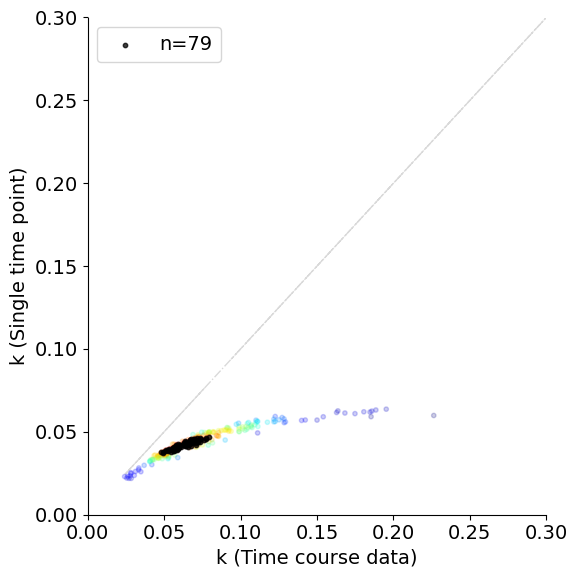

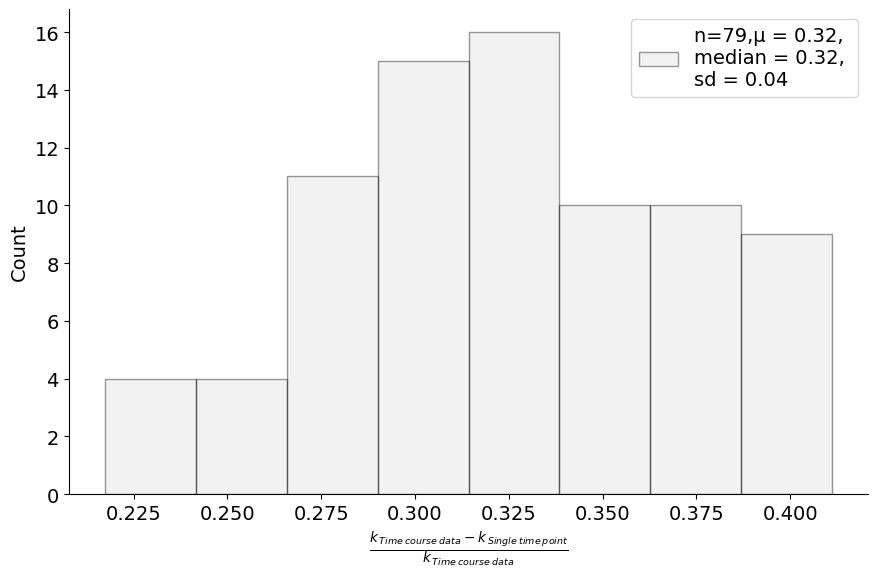

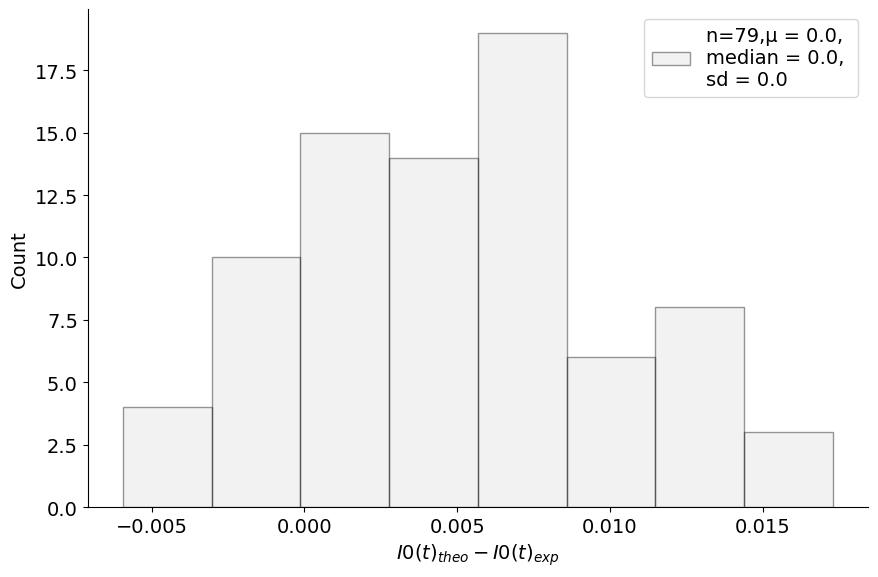

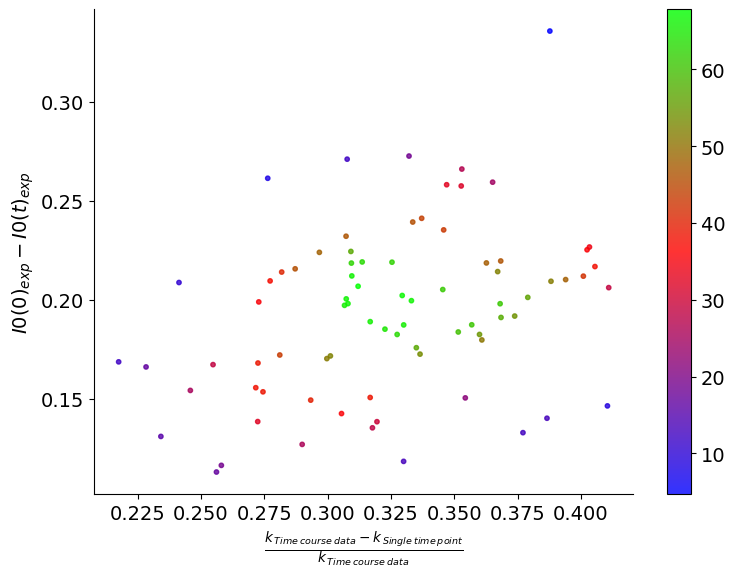

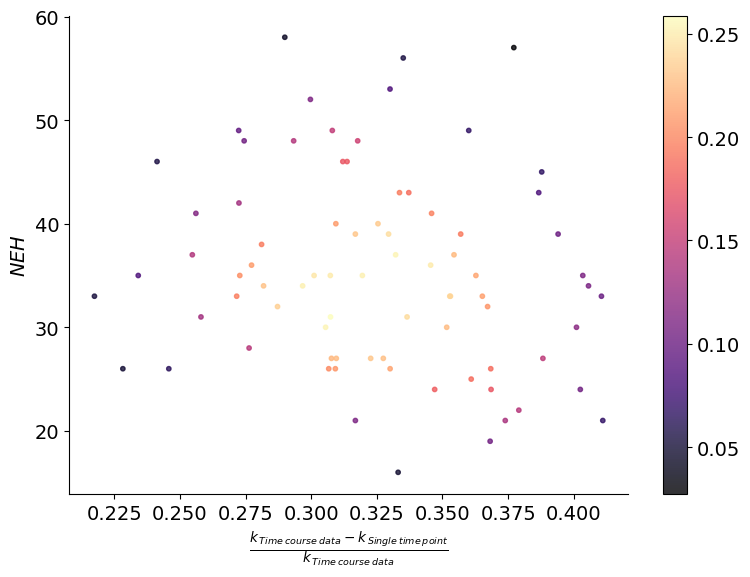

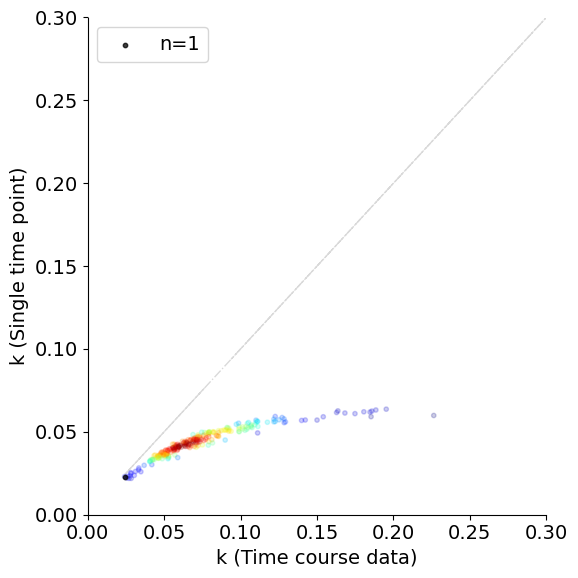

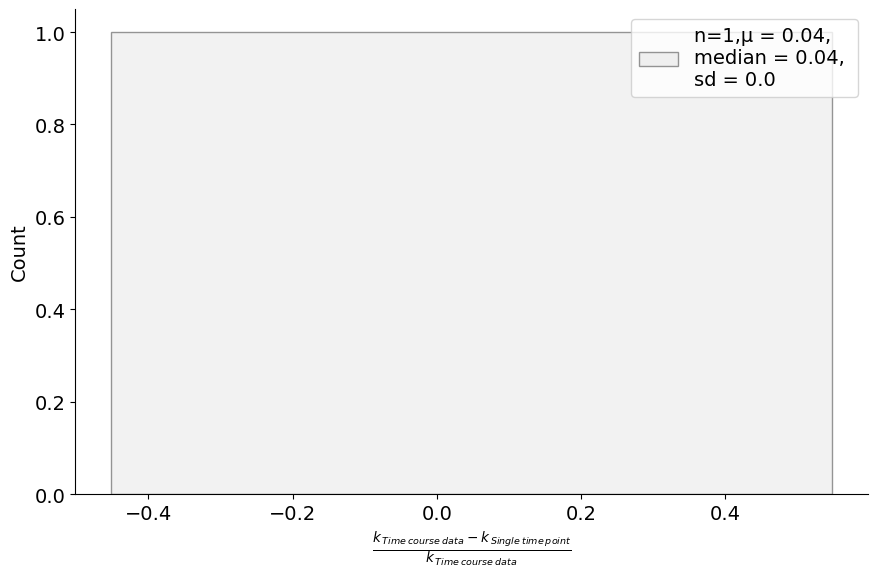

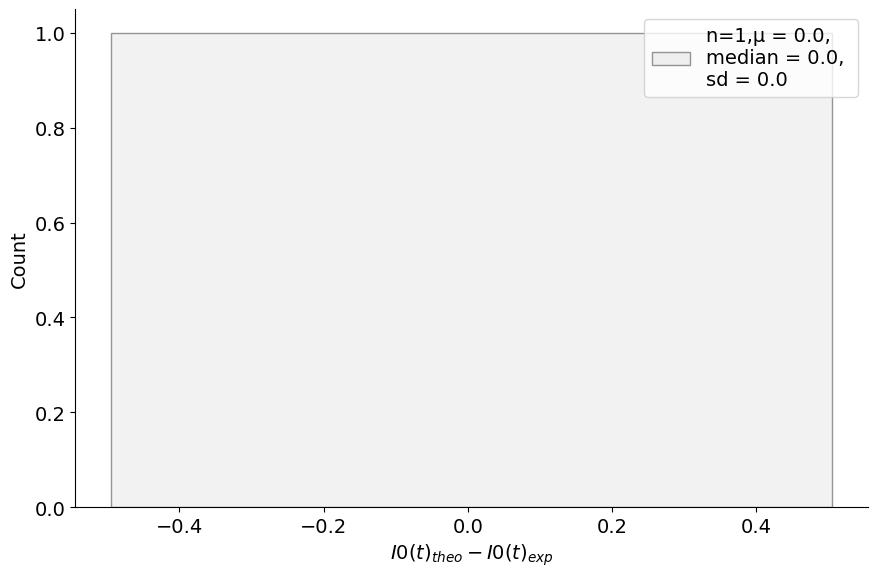

 86%|████████▌ | 6/7 [32:11<05:21, 321.95s/it]


ValueError: Number of dimensions is greater than number of samples. This results in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Note that `gaussian_kde` interprets each *column* of `dataset` to be a point; consider transposing the input to `dataset`.

<Figure size 800x600 with 0 Axes>

In [11]:
for _time in tqdm([1 ,2 ,3 ,6 ,7,13,16]):
    for _rsquared in [0.99,0.95,0.9][::-1]:
        for _numberofterms in range(1,4):
                        
            merged=allmerged.copy()
            merged=merged[(merged.Rsquared.astype('float')>=_rsquared)]
            merged=merged.reset_index(drop=True)
            
            _res=computeAllNewRates(_time,_numberofterms)
            _path1=f"Figures/{organ}/Day_{_time}/r2_{_rsquared}/numberofterms_{_numberofterms}/"
            _path2=f"Figures/{organ}/Day_{_time}/r2_{_rsquared}/numberofterms_{_numberofterms}/subgroup/DenseRegion/"
            _path3=f"Figures/{organ}/Day_{_time}/r2_{_rsquared}/numberofterms_{_numberofterms}/subgroup/10Percent_K_RD/"
            _paths=[_path1,_path2,_path3]
            for _path in _paths:
                if not os.path.exists(_path): os.makedirs(_path)

            _title=f"{organ}_day_{_time}_numberofterms_{_numberofterms}"    

            plot_hitmap(_res.d2ome_k,_res.new_k,_path1,_title)
            plotRateRDDensity(_res,_path1,_title)
            plotI0_expRDDensity(_res,_path1,_title)
            plotI0_I0_t_k_RDDensity(_res,_path1,_title)
            plotNEH_k_RDDensity(_res,_path1,_title)

            clear_output(wait=True)  
            plotSubgroup(_res,_path2,_title,1)
            plotSubgroup(_res,_path3,_title,2)
            
            _res.to_csv(_path1+_title+".csv",index=False)
